In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
sys.path.insert(1, "../")
import grapher
import windowtools

dataset = pd.read_csv("../datasets/financial_sent.zip", compression="zip", encoding="latin-1")
dataset.head()


,Label,Data
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


Plot the count of sentiment spread

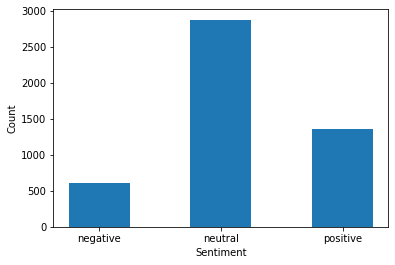

In [32]:
grapher.bar_chart(dataset["Label"].values, 0.5, "Sentiment", "Count")

Convert the string versioned sentiment to integer. Having three categories requires later use of SparseCategoricalCrossentropy.

In [33]:
sentiment = {"positive": 0, "neutral": 1, "negative": 2}

dataset.Label = [sentiment[item] for item in dataset.Label]
dataset.head()

,Label,Data
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,2,The international electronic industry company ...
3,0,With the new production plant the company woul...
4,0,According to the company 's updated strategy f...


Clean up the data

In [34]:
useless_words = ["to", "the", "for", "by", "has", "had", "were", "a", "an", "and", "what", "will", "can", "into", "in", "out", "are", "but", "if", "about", "why", "how", "where", "when", "too", "there", "now"]
punctuation = "!,&.()?:"
def remove_junk(text, removable_data):
    if type(removable_data) == str:
        text = "".join([char for char in text if char not in punctuation])
    else:
        text = " ".join([word for word in text.split() if word not in removable_data])
    return text
def clean_contractions(text):
    text = text.replace(" '","'")
    return text
dataset["Data"] = dataset["Data"].apply(lambda sentence: remove_junk(sentence, punctuation))
dataset["Data"] = dataset["Data"].apply(lambda sentence: remove_junk(sentence, useless_words))
dataset["Data"] = dataset["Data"].apply(lambda sentence: clean_contractions(sentence))
dataset.head()

,Label,Data
0,1,According Gran company no plans move all produ...
1,1,Technopolis plans develop stages area of no le...
2,2,The international electronic industry company ...
3,0,With new production plant company would increa...
4,0,According company's updated strategy years 200...


Create a tokenizer, compute max length for padding, and build the train and test datasets

In [35]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(dataset.Data)
max_sentence_length = np.array([len(x.split()) for x in dataset["Data"].tolist()]).max()
sequences = tokenizer.texts_to_sequences(dataset["Data"].tolist())
padded_sequences = pad_sequences(sequences, padding="post", maxlen=max_sentence_length)
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, dataset.Label, test_size=0.3)

Build the Embedding model and compile to check for accuracy.

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 32, input_length=max_sentence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 45, 32)            364000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 21        
Total params: 364,219
Trainable params: 364,219
Non-trainable params: 0
_________________________________________________________________


Time to train

In [37]:
epochs = 30
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
106/106 [==============================] - 1s 5ms/step - loss: 1.0466 - accuracy: 0.5826 - val_loss: 0.9146 - val_accuracy: 0.5983
Epoch 2/30
106/106 [==============================] - 0s 4ms/step - loss: 0.9082 - accuracy: 0.5848 - val_loss: 0.8673 - val_accuracy: 0.5983
Epoch 3/30
106/106 [==============================] - 0s 4ms/step - loss: 0.8436 - accuracy: 0.6003 - val_loss: 0.8274 - val_accuracy: 0.6204
Epoch 4/30
106/106 [==============================] - 0s 4ms/step - loss: 0.7795 - accuracy: 0.6368 - val_loss: 0.7924 - val_accuracy: 0.6534
Epoch 5/30
106/106 [==============================] - 0s 4ms/step - loss: 0.7332 - accuracy: 0.6607 - val_loss: 0.7628 - val_accuracy: 0.6774
Epoch 6/30
106/106 [==============================] - 0s 4ms/step - loss: 0.6650 - accuracy: 0.6968 - val_loss: 0.7348 - val_accuracy: 0.6912
Epoch 7/30
106/106 [==============================] - 0s 4ms/step - loss: 0.5954 - accuracy: 0.7532 - val_loss: 0.7090 - val_accuracy: 0.7056
Epoch 

Graph the accuracy and loss

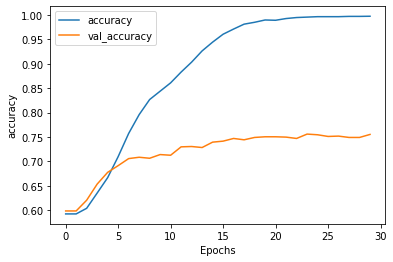

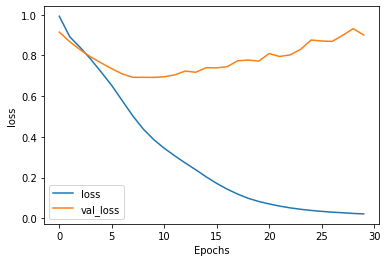

In [38]:
grapher.plot_history_graph(history, "accuracy")
grapher.plot_history_graph(history, "loss")

Insights: Cut epochs down to 10 to get an average of about 90% accuracy for train & 70% for test

Test out using convolution

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 32, input_length=max_sentence_length),
    tf.keras.layers.Conv1D(32, 3, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(3, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 45, 32)            364000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 43, 32)            3104      
_________________________________________________________________
global_average_pooling1d_3 ( (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 367,203
Trainable params: 367,203
Non-trainable params: 0
_________________________________________________________________


Lets train!

In [40]:
epochs = 30
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
106/106 [==============================] - 1s 6ms/step - loss: 1.0251 - accuracy: 0.5437 - val_loss: 0.8839 - val_accuracy: 0.6039
Epoch 2/30
106/106 [==============================] - 0s 5ms/step - loss: 0.8429 - accuracy: 0.6321 - val_loss: 0.7731 - val_accuracy: 0.6713
Epoch 3/30
106/106 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.7038 - val_loss: 0.7062 - val_accuracy: 0.6946
Epoch 4/30
106/106 [==============================] - 0s 5ms/step - loss: 0.5408 - accuracy: 0.7751 - val_loss: 0.6718 - val_accuracy: 0.7160
Epoch 5/30
106/106 [==============================] - 1s 5ms/step - loss: 0.4045 - accuracy: 0.8397 - val_loss: 0.6500 - val_accuracy: 0.7359
Epoch 6/30
106/106 [==============================] - 0s 4ms/step - loss: 0.2887 - accuracy: 0.8945 - val_loss: 0.6577 - val_accuracy: 0.7442
Epoch 7/30
106/106 [==============================] - 0s 5ms/step - loss: 0.2070 - accuracy: 0.9459 - val_loss: 0.6620 - val_accuracy: 0.7531
Epoch 

Lets check the graphs

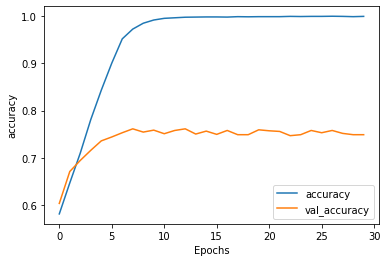

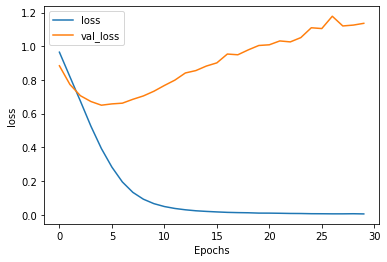

In [41]:
grapher.plot_history_graph(history, "accuracy")
grapher.plot_history_graph(history, "loss")

Insights: Slightly better, probably cut off at 6 or 7 epochs for around 98% train accuracy and 76% test accuracy

Lets try it now using a Bidi GRU!

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 32, input_length=max_sentence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(3, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 45, 32)            364000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                12672     
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 195       
Total params: 376,867
Trainable params: 376,867
Non-trainable params: 0
_________________________________________________________________


In [43]:
epochs = 30
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
106/106 [==============================] - 5s 18ms/step - loss: 0.9712 - accuracy: 0.5835 - val_loss: 0.7920 - val_accuracy: 0.6706
Epoch 2/30
106/106 [==============================] - 1s 11ms/step - loss: 0.6718 - accuracy: 0.6930 - val_loss: 0.7330 - val_accuracy: 0.6891
Epoch 3/30
106/106 [==============================] - 1s 12ms/step - loss: 0.4597 - accuracy: 0.8008 - val_loss: 0.7917 - val_accuracy: 0.6554
Epoch 4/30
106/106 [==============================] - 1s 12ms/step - loss: 0.3268 - accuracy: 0.8527 - val_loss: 0.9173 - val_accuracy: 0.6857
Epoch 5/30
106/106 [==============================] - 1s 12ms/step - loss: 0.2211 - accuracy: 0.9312 - val_loss: 1.0346 - val_accuracy: 0.6671
Epoch 6/30
106/106 [==============================] - 1s 12ms/step - loss: 0.1539 - accuracy: 0.9543 - val_loss: 1.2139 - val_accuracy: 0.6575
Epoch 7/30
106/106 [==============================] - 1s 11ms/step - loss: 0.0922 - accuracy: 0.9752 - val_loss: 1.3257 - val_accuracy: 0.6547

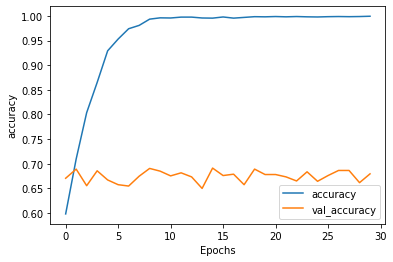

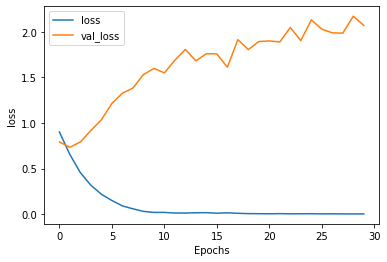

In [44]:
grapher.plot_history_graph(history, "accuracy")
grapher.plot_history_graph(history, "loss")

Insights: Slightly worse, too unstable to trust the results from

Lets try it again but reduce the learning rate to help control loss rate

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 32, input_length=max_sentence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(3, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003), metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 45, 32)            364000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                12672     
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 195       
Total params: 376,867
Trainable params: 376,867
Non-trainable params: 0
_________________________________________________________________


In [46]:
epochs = 30
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
106/106 [==============================] - 5s 18ms/step - loss: 1.0915 - accuracy: 0.4955 - val_loss: 1.0735 - val_accuracy: 0.5983
Epoch 2/30
106/106 [==============================] - 1s 12ms/step - loss: 1.0663 - accuracy: 0.6003 - val_loss: 1.0481 - val_accuracy: 0.5983
Epoch 3/30
106/106 [==============================] - 1s 12ms/step - loss: 1.0420 - accuracy: 0.5856 - val_loss: 1.0191 - val_accuracy: 0.5983
Epoch 4/30
106/106 [==============================] - 1s 12ms/step - loss: 1.0113 - accuracy: 0.5941 - val_loss: 0.9861 - val_accuracy: 0.5983
Epoch 5/30
106/106 [==============================] - 1s 12ms/step - loss: 0.9832 - accuracy: 0.5839 - val_loss: 0.9520 - val_accuracy: 0.5983
Epoch 6/30
106/106 [==============================] - 1s 12ms/step - loss: 0.9510 - accuracy: 0.5880 - val_loss: 0.9253 - val_accuracy: 0.5983
Epoch 7/30
106/106 [==============================] - 1s 12ms/step - loss: 0.9143 - accuracy: 0.6068 - val_loss: 0.9119 - val_accuracy: 0.5983

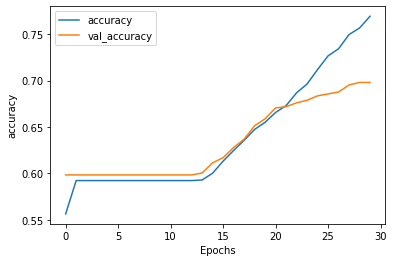

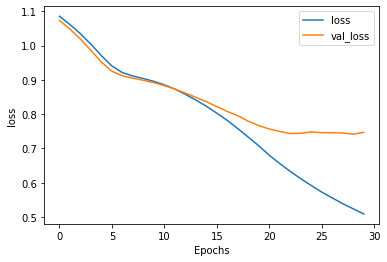

In [47]:
grapher.plot_history_graph(history, "accuracy")
grapher.plot_history_graph(history, "loss")

Insights: Definitely more stable than before. Should probably stop out at 18 epochs for ~70% train accuracy and ~67% test accuracy

Lets try it now with LSTMs

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 32, input_length=max_sentence_length),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(3, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 45, 32)            364000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 99        
Total params: 372,419
Trainable params: 372,419
Non-trainable params: 0
_________________________________________________________________


In [49]:
epochs = 30
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
106/106 [==============================] - 3s 16ms/step - loss: 0.9826 - accuracy: 0.5879 - val_loss: 0.9039 - val_accuracy: 0.5983
Epoch 2/30
106/106 [==============================] - 1s 12ms/step - loss: 0.8323 - accuracy: 0.6085 - val_loss: 0.7571 - val_accuracy: 0.6802
Epoch 3/30
106/106 [==============================] - 1s 12ms/step - loss: 0.5566 - accuracy: 0.7678 - val_loss: 0.7206 - val_accuracy: 0.7015
Epoch 4/30
106/106 [==============================] - 1s 12ms/step - loss: 0.3935 - accuracy: 0.8436 - val_loss: 0.8470 - val_accuracy: 0.6802
Epoch 5/30
106/106 [==============================] - 1s 11ms/step - loss: 0.3170 - accuracy: 0.8622 - val_loss: 0.9491 - val_accuracy: 0.6431
Epoch 6/30
106/106 [==============================] - 1s 11ms/step - loss: 0.2865 - accuracy: 0.8669 - val_loss: 1.0811 - val_accuracy: 0.6135
Epoch 7/30
106/106 [==============================] - 1s 12ms/step - loss: 0.2759 - accuracy: 0.8964 - val_loss: 1.0110 - val_accuracy: 0.6678

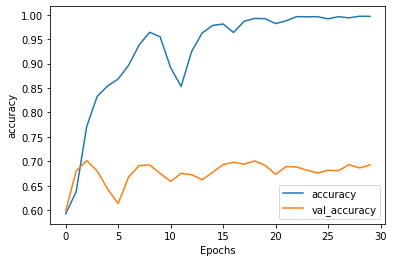

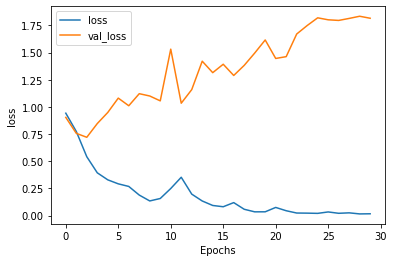

In [50]:
grapher.plot_history_graph(history, "accuracy")
grapher.plot_history_graph(history, "loss")

Insights: Pretty bad loss rate even without Bidi. Unusable with the instability

Lets retry with a lower learning rate

In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 32, input_length=max_sentence_length),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(3, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003), metrics=["accuracy"])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 45, 32)            364000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 99        
Total params: 372,419
Trainable params: 372,419
Non-trainable params: 0
_________________________________________________________________


In [52]:
epochs = 30
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
106/106 [==============================] - 4s 17ms/step - loss: 1.0969 - accuracy: 0.3227 - val_loss: 1.0780 - val_accuracy: 0.5983
Epoch 2/30
106/106 [==============================] - 1s 13ms/step - loss: 1.0714 - accuracy: 0.5974 - val_loss: 1.0483 - val_accuracy: 0.5983
Epoch 3/30
106/106 [==============================] - 1s 13ms/step - loss: 1.0378 - accuracy: 0.6022 - val_loss: 1.0043 - val_accuracy: 0.5983
Epoch 4/30
106/106 [==============================] - 1s 12ms/step - loss: 0.9899 - accuracy: 0.6001 - val_loss: 0.9427 - val_accuracy: 0.5983
Epoch 5/30
106/106 [==============================] - 1s 13ms/step - loss: 0.9367 - accuracy: 0.5970 - val_loss: 0.9205 - val_accuracy: 0.5983
Epoch 6/30
106/106 [==============================] - 1s 12ms/step - loss: 0.9264 - accuracy: 0.5964 - val_loss: 0.9146 - val_accuracy: 0.5983
Epoch 7/30
106/106 [==============================] - 1s 12ms/step - loss: 0.9095 - accuracy: 0.6000 - val_loss: 0.9092 - val_accuracy: 0.5983

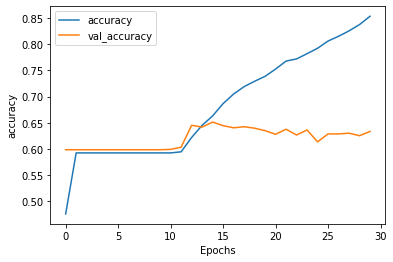

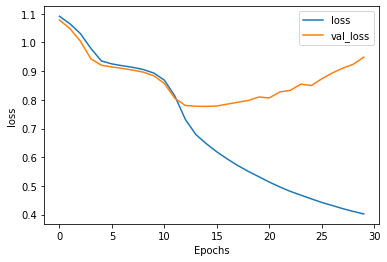

In [53]:
grapher.plot_history_graph(history, "accuracy")
grapher.plot_history_graph(history, "loss")

Insights: Still not that good. Probably cap out at 15-18 epochs for ~66-68% accuracy for train and test

Lets make the LSTM Bidi with the same learning rate

In [57]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 32, input_length=max_sentence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(3, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003), metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 45, 32)            364000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 195       
Total params: 380,835
Trainable params: 380,835
Non-trainable params: 0
_________________________________________________________________


In [58]:
epochs = 100
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/100
106/106 [==============================] - 5s 22ms/step - loss: 1.0908 - accuracy: 0.5535 - val_loss: 1.0720 - val_accuracy: 0.5983
Epoch 2/100
106/106 [==============================] - 2s 15ms/step - loss: 1.0652 - accuracy: 0.5909 - val_loss: 1.0411 - val_accuracy: 0.5983
Epoch 3/100
106/106 [==============================] - 2s 16ms/step - loss: 1.0307 - accuracy: 0.5957 - val_loss: 0.9961 - val_accuracy: 0.5983
Epoch 4/100
106/106 [==============================] - 2s 16ms/step - loss: 0.9821 - accuracy: 0.5943 - val_loss: 0.9335 - val_accuracy: 0.5983
Epoch 5/100
106/106 [==============================] - 2s 15ms/step - loss: 0.9388 - accuracy: 0.5791 - val_loss: 0.9090 - val_accuracy: 0.5983
Epoch 6/100
106/106 [==============================] - 2s 15ms/step - loss: 0.9202 - accuracy: 0.5837 - val_loss: 0.9032 - val_accuracy: 0.5983
Epoch 7/100
106/106 [==============================] - 2s 15ms/step - loss: 0.8968 - accuracy: 0.5968 - val_loss: 0.8978 - val_accuracy:

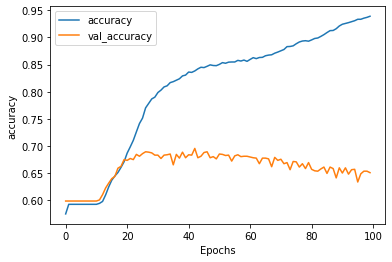

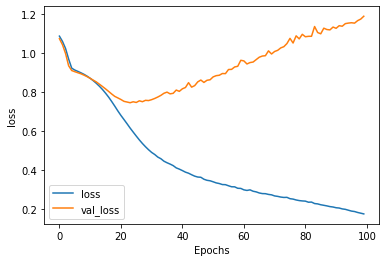

In [59]:
grapher.plot_history_graph(history, "accuracy")
grapher.plot_history_graph(history, "loss")

Insights: Not much better. Should probably stop at about 28 epochs for ~66% train & test accuracy